# Setup

In [2]:
# Imports
from pprint import pprint
from copy import copy
import sqlite3 as sql
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from bitarray import bitarray
from collections import Counter

In [3]:
def arrayEquals(a1, a2):
    if len(a1) != len(a2):
        return False
    else:
        for i in range(len(a1)):
            if a1[i] != a2[i]:
                return False
    return True

def binaryRap(value):
    res = [0 for i in range(8)]
    if value >= 0:
        tmp = 0
        for i in range(1,8):
            j = 7-i
            if tmp + 2 ** j <= value:
                tmp += 2 ** j
                res[j] = 1
    else:
        tmp = -128
        res[7] = 1
        for i in range(1,8):
            j = 7-i
            if tmp + 2 ** j <= value:
                tmp += 2 ** j
                res[j] = 1
    res.reverse()
    return res

def getMiddlePoints(arr):
    l = len(arr)-1
    res = [0 for i in range(l)]
    for i in range(l):
        res[i] = (arr[i]+arr[i+1]) / 2
    return res
    
n_bits = 8
COLORS = ["royalblue", "orange", "green", "tomato", "purple", "turquoise"]

    
mydb_c = sql.connect("my.db")
mydb_c.row_factory = sql.Row
mydb = mydb_c.cursor()
gold_c = sql.connect("data/gold.db")
gold = gold_c.cursor()
print("DONE")

DONE


All the weights are in the ragne -

# Preliminary Data

## Injections distributions

### Vertical position (vertical depth)

200


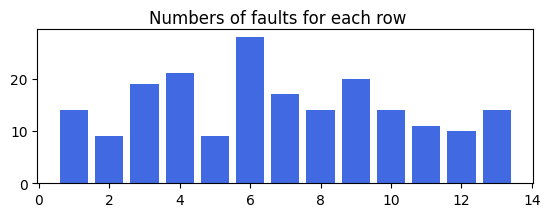

In [4]:
# vertial value faults barchart
mydb.execute("select p1 from faults")
row = mydb.fetchone()[0]
faultVertHist = []
faultDepths = {}
while row is not None:
    if row in faultDepths:
        faultDepths[row] += 1
    else:
        faultDepths.update({row : 1})
    faultVertHist.append(row)

    row = mydb.fetchone()
    if row is not None:
        row = row[0]
#pprint(faultDepths)
f = plt.figure()
f.set_figheight(2)
plt.bar(faultDepths.keys(), faultDepths.values(), color="royalblue")
print(sum(faultDepths.values()))
plt.suptitle("Numbers of faults for each row")
plt.savefig("figures/FaultsPerRow", bbox_inches="tight")
plt.show()

### Horizontal position (horizontal depth)

200


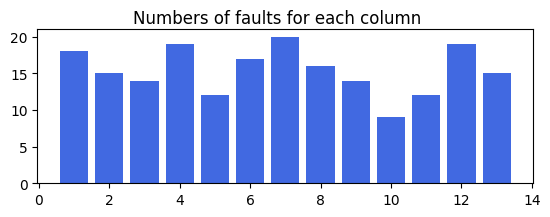

In [5]:
# vertial value faults barchart
mydb.execute("select p2 from faults")
row = mydb.fetchone()[0]
faultDepthsHorizontal = {}
faultHorzHist = []
while row is not None:
    if row in faultDepthsHorizontal:
        faultDepthsHorizontal[row] += 1
    else:
        faultDepthsHorizontal.update({row : 1})
    faultHorzHist.append(row)
        
    row = mydb.fetchone()
    if row is not None:
        row = row[0]
#pprint(faultDepths)
print(sum(faultDepthsHorizontal.values()))
f = plt.figure()
f.set_figheight(2)
plt.bar(faultDepthsHorizontal.keys(), faultDepthsHorizontal.values(), color="royalblue")
plt.suptitle("Numbers of faults for each column")
plt.savefig("figures/FaultsPerCol", bbox_inches="tight")
plt.show()

In [6]:
print(min(faultVertHist))
print(max(faultVertHist))
print(min(faultHorzHist))
print(max(faultHorzHist))

1
13
1
13


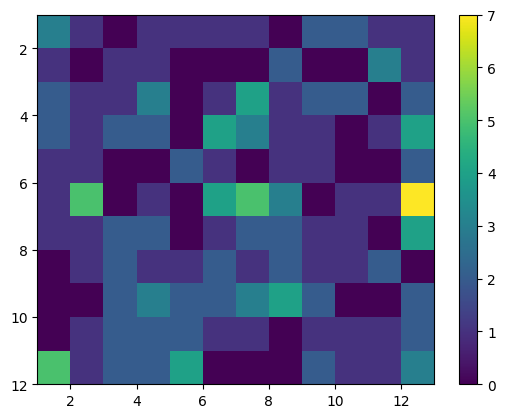

In [7]:
fig, axes = plt.subplots()
arr, _, _, im = axes.hist2d(faultHorzHist, faultVertHist, bins=[[i for i in range(1,14)], [i for i in range(1,13)]])
axes.invert_yaxis()
fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=arr.min(), vmax=arr.max())), ax=axes)
plt.savefig("figures/faults_per_pe_heatmap", bbox_inches="tight")

### Bit position injections

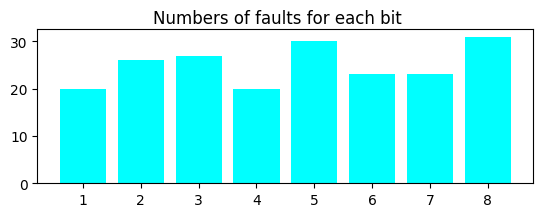

In [8]:
# vertial value faults barchart
mydb.execute("select bit from faults")
row = mydb.fetchone()[0]
faultBits = {}
while row is not None:
    if row in faultBits:
        faultBits[row] += 1
    else:
        faultBits.update({row : 1})

    row = mydb.fetchone()
    if row is not None:
        row = row[0]
#pprint(faultDepths)
f = plt.figure()
f.set_figheight(2)
plt.bar(faultBits.keys(), faultBits.values(), color="cyan")
plt.suptitle("Numbers of faults for each bit")
plt.show()

## Stimuli distribution

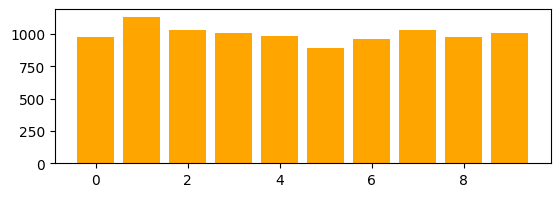

In [9]:
mydb.execute("select label, count(*) from stimuli group by label")
rows = mydb.fetchall()
rows = [tuple(r)[1] for r in rows]
f = plt.figure()
f.set_figheight(2)
plt.bar(range(10), rows, color="orange")
plt.savefig("figures/stimuliDistribution", bbox_inches="tight")
plt.show()

# Statistical analysis

In [10]:
faultTypes = ["masked", "good", "accept", "warning", "critical"]

### Statistics variables
# masked, good, accept, warning, critical
safety = [0, 0, 0, 0, 0]
# safety per channel. It is a dictionary devided by 
safetyPerChannel = [{},{},{},{},{}]
channelsTot = [0 for i in range(6)]
# vertical depth safety (only accept, warning and critical)
vertSafety = {0: {}, 1: {}, 2: {}, 3: {}, 4: {}}
# horizontal depth safety (only accept, warning and critical)
horSafety = {0: {}, 1: {}, 2: {}, 3: {}, 4: {}}
# bit position safety
bitPosSafety = {i:{} for i in range(5)}
# safety based on stimulus
stimuliSafety = {i:{} for i in range(5)}
# fault value
faultValueSafety = { i:[0, 0] for i in range(5) }
# fault value at 1 w.r.t. injected bit
bitPosStuckAt1 = {i: {} for i in range(5)}

# Total injection-stimulus pairs
total = 0

mydb.execute("""select * from faults as f, injections as i, stimuli as s
                    where i.stimulus_id = s.id 
                        and stimulus_id <= 1000 
                        and i.fault_id=f.id 
                    order by stimulus_id""")
# Order is id, channel, type, p1, p2, bit, value, stimulus_id, fault_id, probs...
row = mydb.fetchone()

#Indeces
rowKeys = row.keys()
probs_start_index = rowKeys.index("prob0")
channel_index = rowKeys.index("channel")
fault_index = rowKeys.index("fault_id")
stimulus_index = rowKeys.index("stimulus_id")
rowP_index = rowKeys.index("p1")
colP_index = rowKeys.index("p2")
bit_index = rowKeys.index("bit")
label_index = rowKeys.index("label")
fault_value_index = rowKeys.index("value")

row = tuple(row)
gold_stim = -1
while row is not None:
    stimulus = row[stimulus_index]
    fault  = row[fault_index]
    probs = row[probs_start_index:probs_start_index+10]
    channel = row[channel_index]
    rowP = row[rowP_index]
    colP = row[colP_index]
    bit = row[bit_index]
    label = row[label_index]
    fault_value = row[fault_value_index]
    
    total = total + 1
    if stimulus != gold_stim:
        gold.execute("select * from gold where stimulus = {}".format(stimulus))
        grow = gold.fetchone()
        [gold_stim, gold_probs] = [grow[0], grow[1:]]
        gold_pred = max(gold_probs)
        gold_label =  gold_probs.index(gold_pred)

    pred = max(probs)
    pred_label = probs.index(pred)

    # Masked
    if arrayEquals(probs, gold_probs):
        ftype = 0
    elif pred >= gold_pred and gold_label == pred_label: # good
        ftype = 1
    elif gold_label == pred_label and abs(pred-gold_pred)/gold_pred >= .05: # accept
        ftype = 2
    elif gold_label == pred_label: # warning
        ftype = 3
    else: # critical
        ftype = 4

    # General safety
    safety[ftype] += 1
    # Channel related
    if channel in safetyPerChannel[ftype]:
        safetyPerChannel[ftype][channel] += 1
    else:
        safetyPerChannel[ftype].update({channel: 1})
    channelsTot[channel-1] += 1
    
    # Vertical depth safety
    if rowP in vertSafety[ftype]:
        vertSafety[ftype][rowP] += 1
    else:
        vertSafety[ftype].update({rowP : 1})
    
    # horizontal safety
    if colP in horSafety[ftype]:
        horSafety[ftype][colP] += 1
    else:
        horSafety[ftype].update({colP: 1})
    
    #bit positions
    if bit in bitPosSafety[ftype]:
        bitPosSafety[ftype][bit] += 1
    else:
        bitPosSafety[ftype].update({bit : 1})   
    
    # fault value
    faultValueSafety[ftype][fault_value] += 1
    
    # bit pos w.r.t fault value
    if fault_value == 1:
        if bit in bitPosStuckAt1[ftype]:
            bitPosStuckAt1[ftype][bit] += 1
        else:
            bitPosStuckAt1[ftype].update({bit: 1})
    
    # stimului safety
    if label in stimuliSafety[ftype]:
        stimuliSafety[ftype][label] += 1
    else:
        stimuliSafety[ftype].update({label: 1})


    row = mydb.fetchone()
    if row is not None:
        row = tuple(row)

In [11]:
pprint(bitPosStuckAt1)

{0: {1: 4815, 2: 411, 3: 1544, 4: 1535, 5: 2860, 6: 6450, 7: 5344, 8: 11649},
 1: {1: 1191, 2: 7858, 3: 4985, 4: 4493, 5: 5771, 6: 4706, 7: 2420, 8: 2248},
 2: {1: 12, 2: 4923, 3: 2217, 4: 1614, 5: 477, 6: 59, 7: 2},
 3: {1: 981, 2: 2659, 3: 2191, 4: 4322, 5: 4880, 6: 2782, 7: 1234, 8: 1103},
 4: {1: 1, 2: 149, 3: 63, 4: 36, 5: 12, 6: 3}}


# Stats visualization

## General safety

Masked: 54.68%
good: 24.66
---------------- (Safe   79.338%)
accept: 5.42%
critical: 0.22%
---------------- (Unsafe 20.662%)


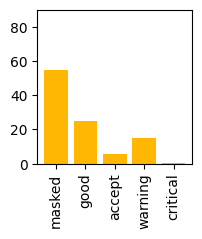

In [12]:
##### General statistics
perc = [s / total * 100 for s in safety]
safePerc = sum(perc[:2])
unsafePerc = sum(perc[2:])

print("""Masked: {:.2f}%
good: {:.2f}
---------------- (Safe   {:2.3f}%)
accept: {:.2f}%
warning: {:.2f}%
critical: {:.2f}%
---------------- (Unsafe {:2.3f}%)""".format(perc[0], perc[1], safePerc, perc[2], perc[3], perc[4], unsafePerc))

f = plt.figure(figsize=[2, 2])
plt.bar(faultTypes, perc, color="#FFB703")
plt.ylim(top=90)
plt.xticks(rotation=90, ha='center')
plt.savefig("figures/safety", bbox_inches="tight")
plt.show()

## Per-channel safety

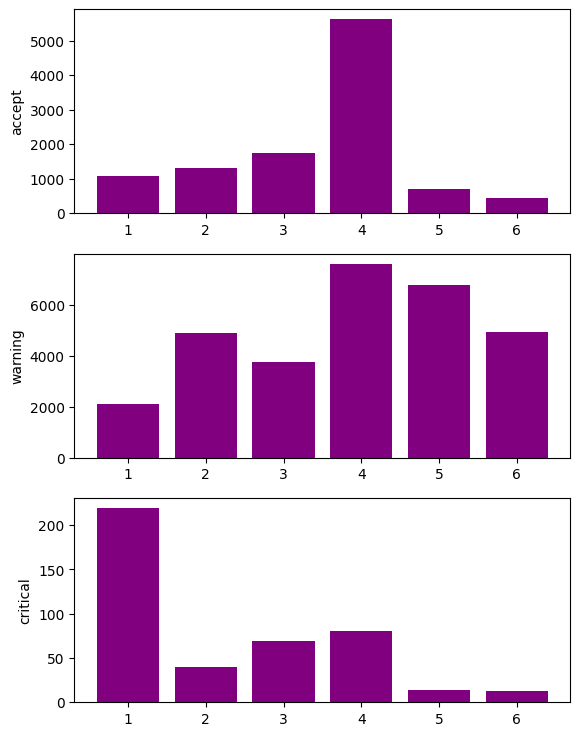

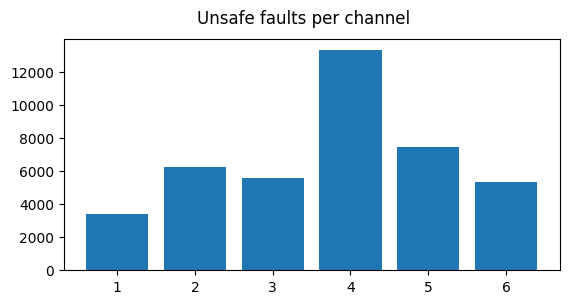

In [13]:
# Per Channel 
Total = [0 for i in range(0,7)]
f = plt.figure()
f.set_figheight(9)
for i, el in enumerate(safetyPerChannel):
    if i < 2:
        continue 
    plt.subplot(3,1, i-1)
    plt.bar(el.keys(), el.values(), color="purple")
    plt.ylabel("%s" % faultTypes[i])
    for i,e in el.items():
        Total[i] += e

plt.savefig("figures/number_faults_per_channel")
plt.show()

f = plt.figure()
f.set_figheight(3)
plt.bar(range(1,7), Total[1:])
plt.suptitle("Unsafe faults per channel")

plt.savefig("figures/unsafe_faults_per_channel")
plt.show()

## Safety based on vertical injections

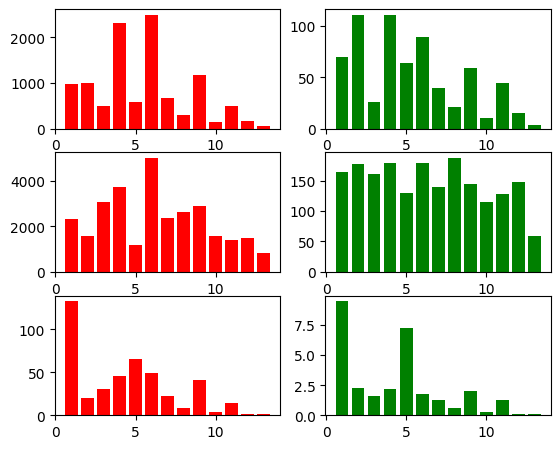

In [14]:
# Vertical
#pprint(vertSafety)
startIndex = 2
f = plt.figure()
f.set_figheight(9)
pos = 1
for i, el in vertSafety.items():
    if i < 2:
        continue
    # Since the distribution of vertical depth is not uniform, we normalize w.r.t. the number of injections
    values = [v/faultDepths[i] for i,v in el.items()]
    
    plt.subplot(5,2,pos)
    plt.bar(el.keys(), el.values(), color="red")
    plt.subplot(5,2,pos+1)
    plt.bar(el.keys(), values, color="green")
    pos += 2
    
plt.savefig("figures/number_faults_per_row", bbox_inches="tight")
plt.show() 

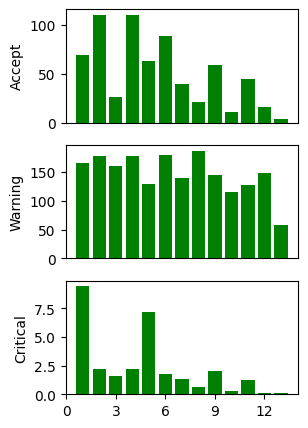

In [15]:
# Vertical
#pprint(vertSafety)
startIndex = 2
pos = 1
f = plt.figure(figsize=[3,5])

yLabels = ["Masked", "Good", "Accept", "Warning", "Critical"]
yLabi = 0

fdsa=-1
for el in vertSafety.values(): 
    fdsa+=1
    if fdsa < 2:
        continue
    
        # Since the distribution of vertical depth is not uniform, we normalize w.r.t. the number of injections
    values = [v/faultDepths[i] for i,v in el.items()]
    
    plt.subplot(3,1,pos)
    
    if pos < 3:
        plt.tick_params(bottom=False, labelbottom=False)
    
    plt.xticks([i*3 for i in range(int(15/3))])
    plt.ylabel(yLabels[fdsa])
    plt.bar(el.keys(), values, color="green")
    pos += 1

plt.savefig("figures/safety_per_row_normalized", bbox_inches="tight")
plt.show() 

As expected, the smaller the depth, the more faults will be associated. Note also that most of the critical errors come from the first 9 rows.

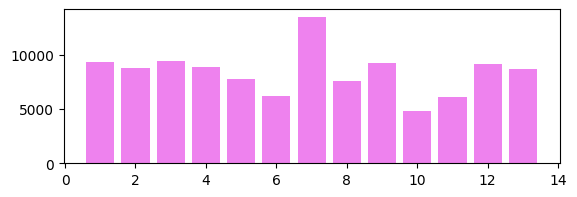

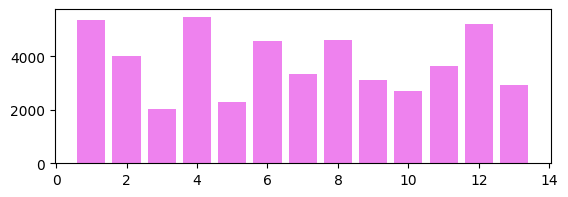

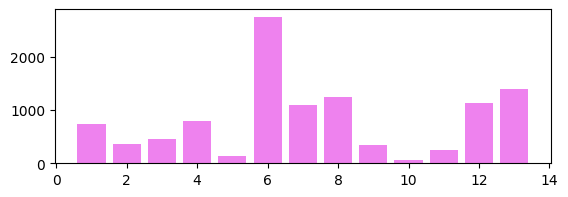

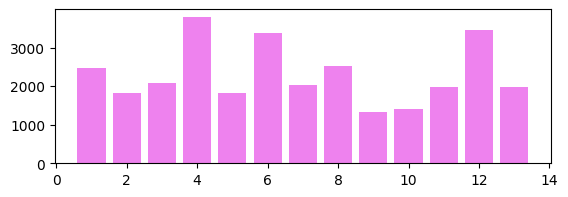

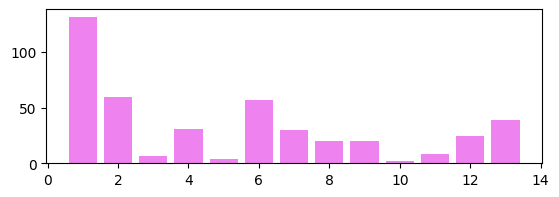

In [16]:
# Horizontal
for el in horSafety.values():
    f = plt.figure()
    f.set_figheight(2)
    plt.bar(el.keys(), el.values(), color="violet")
    plt.show() 

## Bit position

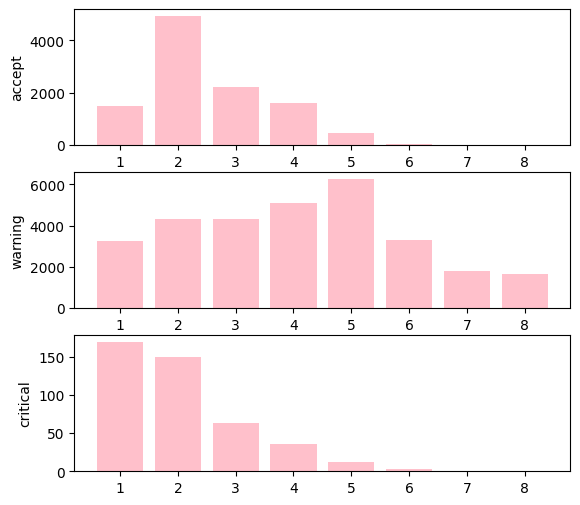

In [17]:
# Bit Position
f = plt.figure()
f.set_figheight(6)
Total = [0 for i in range(0,9)]
for i, el in enumerate(bitPosSafety.values()):
    if i < 2:
        continue
    plt.subplot(3,1,i-1)
    
    for j in range(1,9):
        if not j in el:
            el.update({j :0})
    
    plt.bar(el.keys(), el.values(), color="pink")
    plt.ylabel(f"{faultTypes[i]}")
plt.savefig("figures/number_faults_per_bit", bbox_inches="tight")
plt.show()

### Aggregate bit positions (unsafe - 2,3,4)

{1: 4925, 2: 9429, 3: 6614, 4: 6770, 5: 6756, 6: 3358, 7: 1797, 8: 1675}


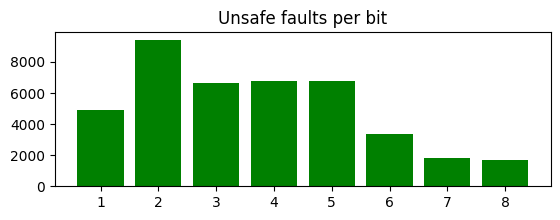

In [18]:
start = 2
bitPosTot = { i:0 for i in range(1, n_bits+1) }

for i in range(start,5):
    for el in bitPosSafety[i].keys():
        bitPosTot[el] += bitPosSafety[i][el]
print(bitPosTot)
f = plt.figure()
f.set_figheight(2)
plt.bar(bitPosTot.keys(), bitPosTot.values(), color="green")
plt.title("Unsafe faults per bit")
plt.show()

### Aggregate bit positions (2,3,4) normalized w.r.t. the number of injections per that bit

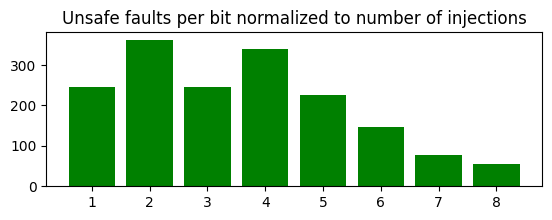

In [19]:
bitPosNormalized = { i:0 for i in faultBits.keys() }
for key in faultBits.keys():
    bitPosNormalized[key] = bitPosTot[key]/faultBits[key]
#pprint(bitPosNormalized)
f = plt.figure()
f.set_figheight(2)
plt.bar(bitPosNormalized.keys(), bitPosNormalized.values(), color="green")
plt.title("Unsafe faults per bit normalized to number of injections")
plt.savefig("figures/number_unsafe_per_bit")
plt.show()

#### Bit depth faults distribution
Note: in this context the higher the number of the bit, the higher its importance. In other words, the MSB is bit 1

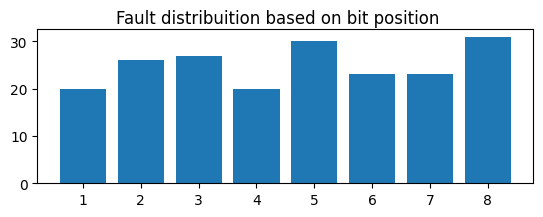

200


In [20]:
mydb.execute("select bit from faults")
row = mydb.fetchone()[0]
faultBits = {}
while row is not None:
    if row in faultBits:
        faultBits[row] += 1
    else:
        faultBits.update({row : 1})

    row = mydb.fetchone()
    if row is not None:
        row = row[0]
#pprint(faultDepths)
f = plt.figure()
f.set_figheight(2)
plt.bar(faultBits.keys(), faultBits.values())
plt.suptitle("Fault distribuition based on bit position")
plt.show()
print(sum(faultBits.values()))

Clearly, bits 6,7,8 are the least problematic, since they are the least important. On the other hand, bit 4 seems to be the most "weak" bit followd by bit 2 and 3. Looking at bits distribution in the weights, 

## Aggregate bit positions (all types)

{8: 57117, 7: 40893, 5: 45381, 2: 33328, 3: 39431, 6: 37080, 1: 28294, 4: 27832}


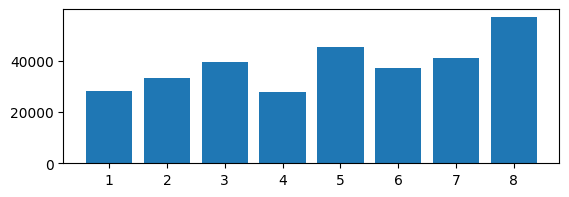

In [21]:
start = 0
bitPosTot = copy(bitPosSafety[start])
for i in range(start,5):
    for el in bitPosSafety[i].keys():
        bitPosTot[el] += bitPosSafety[i][el]
print(bitPosTot)
f = plt.figure()
f.set_figheight(2)
plt.bar(bitPosTot.keys(), bitPosTot.values())
plt.show()

In [22]:
# NON STA FUNZIONANDO E NON SO IL PERCHÈ!
# Mi aspetto che la distribuzione 

totBits = sum(bitPosTot.values())
tot = sum(faultBits.values())
print([el / totBits for el in bitPosTot.values()])
print([el / tot for el in faultBits.values()])

[0.18463194507299033, 0.1321875121219566, 0.14669506975781946, 0.10773348504635437, 0.12746156531633457, 0.11986190667063189, 0.09146097053233168, 0.08996754548158109]
[0.15, 0.1, 0.13, 0.115, 0.115, 0.1, 0.155, 0.135]


## fault types w.r.t stimuli

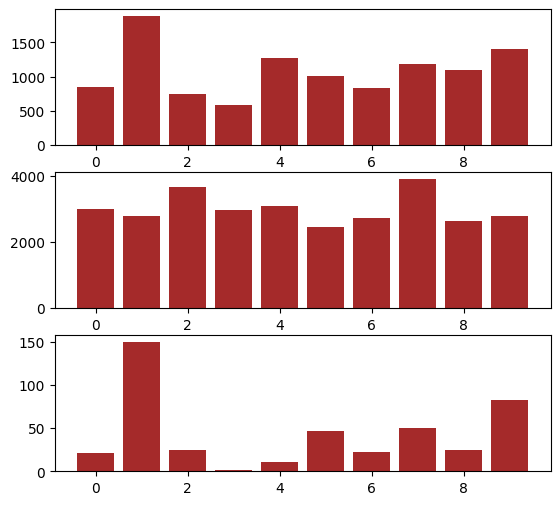

In [23]:
f = plt.figure()
f.set_figheight(6)
for i, el in stimuliSafety.items():
    if i < 2:
        continue
    plt.subplot(3,1,i-1)
    plt.bar(el.keys(), el.values(), color="brown")
plt.savefig("figures/faults_per_stimulus")
plt.show()

## Fault w.r.t. fault value

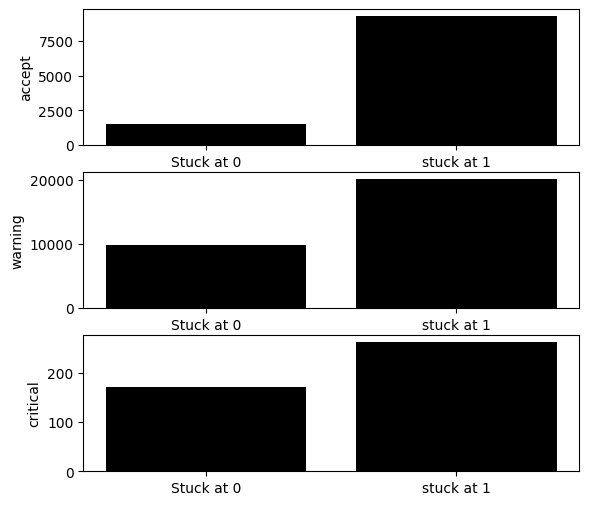

In [24]:
start = 2

f = plt.figure()
f.set_figheight(6)
for tipo, el in faultValueSafety.items():
    if tipo <=1:
        continue
    plt.subplot(3,1,tipo-1)
    plt.bar(["Stuck at 0", "stuck at 1"], el, color="black")
    plt.ylabel(f"{faultTypes[tipo]}")
plt.savefig("figures/fault_per_fault_value")
plt.show()

## 2d histogram of fault values and fault bits (normalized)

{1: 20, 2: 26, 3: 27, 4: 20, 5: 30, 6: 23, 7: 23, 8: 31}


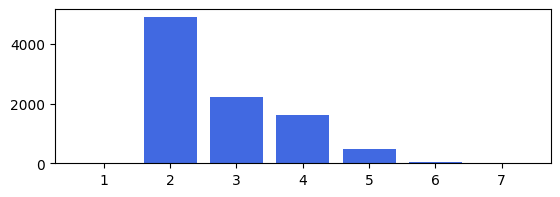

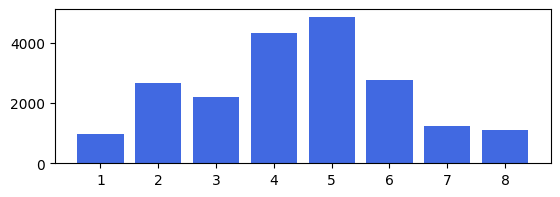

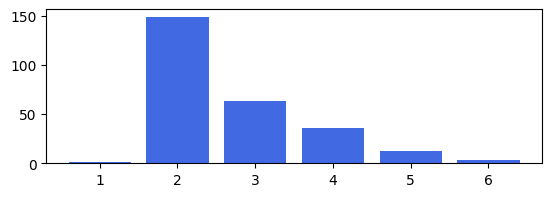

<BarContainer object of 8 artists>

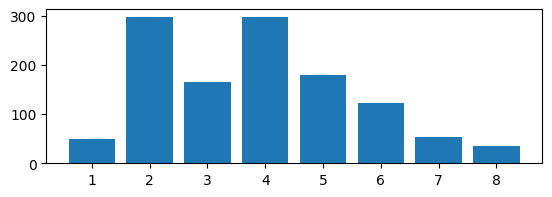

In [25]:
pprint(faultBits)
start = 2
Total = [0 for i in range(0, 9)]
for i,el in bitPosStuckAt1.items():
    if i < start:
        continue
        
    f = plt.figure()
    f.set_figheight(2)
    plt.bar(el.keys(), el.values(), color=COLORS[0])
    plt.show()
    
    for j, k in el.items():
        Total[j] += k
        
Total = [Total[j] / faultBits[j] for j in range(1,9)]
f = plt.figure()
f.set_figheight(2)
plt.bar([i for i in range(1,9)], Total)
        

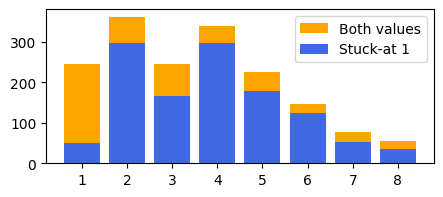

In [29]:
#plt.subplot(1,2,1)

f = plt.figure(figsize=[5,2])
#plt.xlabel("Stuck-at 1 faults")
#plt.subplot(1,2,2)
plt.bar(bitPosNormalized.keys(), bitPosNormalized.values(), color=COLORS[1])
plt.bar([i for i in range(1,9)], Total, color=COLORS[0])
plt.legend(["Both values", "Stuck-at 1"])
#plt.xlabel("Both values")
plt.savefig("figures/stuck-at_comparison")
plt.show()